In [1]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [2]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

Factor Group        Field ID         Field Name FactSet Screening Formula  \
0   Asset Data  DAYS_SINCE_RPT  Days Since Report     QFL_DAYS_SINCE_RPT(0)   
1   Asset Data     DAYS_TO_RPT     Days to Report        QFL_DAYS_TO_RPT(0)   
2   Asset Data        ADR_FLAG           ADR Flag           QFL_ADR_FLAG(0)   
3   Asset Data      BANKRUPTCY    Bankruptcy Flag         QFL_BANKRUPTCY(0)   
4   Asset Data    PRIMARY_LIST    Primary Listing       QFL_PRIMARY_LIST(0)   

              Data Source                                     Unnamed: 6  \
0       FactSet Estimates  'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',   
1       FactSet Estimates        'Days to Report': 'QFL_DAYS_TO_RPT(0)',   
2  FactSet Reference Data                 'ADR Flag': 'QFL_ADR_FLAG(0)',   
3  FactSet Reference Data        'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',   
4  FactSet Reference Data      'Primary Listing': 'QFL_PRIMARY_LIST(0)',   

  Currency  Shares CACCESS       Search Keywords Data Type String Length  
0     None       0   00QFL  asset,data,estimates   INTEGER           NaN  
1     None       0   00QFL  asset,data,estimates   INTEGER           NaN  
2     None       0   00QFL  asset,reference,data   INTEGER           NaN  
3     None       0   00QFL  asset,reference,data   INTEGER           NaN  
4     None       0   00QFL  asset,reference,data   INTEGER           NaN

In [3]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [4]:
qfl_factors = qfl_solvency # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [5]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [6]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [7]:
qfl_df = df

In [8]:
qfl_df.head()

BENCHMARK_ID         DATE SECURITY_ID    Weight             proper_name  \
0        890100  30-Nov-2020    03783310  4.204100              Apple Inc.   
1        890100  30-Nov-2020    59491810  3.141281   Microsoft Corporation   
2        890100  30-Nov-2020    02313510  2.735749        Amazon.com, Inc.   
3        890100  30-Nov-2020    30303M10  1.356526  Facebook, Inc. Class A   
4        890100  30-Nov-2020    02079K10  1.085045   Alphabet Inc. Class C   

           fg_gics_sector         proper  p_total_return qfl_size_class  \
0  Information Technology  United States       11.457372       Mega Cap   
1  Information Technology  United States        3.900588       Mega Cap   
2  Consumer Discretionary  United States        2.805829       Mega Cap   
3  Communication Services  United States       -1.375598       Mega Cap   
4  Communication Services  United States       -0.503194       Mega Cap   

   qfl_mkt_val_sec  QFL_CURR_RATIO(0,CT)  QFL_CURR_RATIO(0,FY0)  \
0        2024064.4              1.363604               1.363604   
1        1618475.4              2.527649               2.515765   
2        1589567.8              1.108496               1.097048   
3         665827.3              5.508958               4.399455   
4         580810.4              3.410145               3.374052   

   QFL_CURR_RATIO(0,FY1)  QFL_CURR_RATIO(0,FY2)  QFL_CURR_RATIO(0,FY3)  \
0               1.424344               1.459778               1.763542   
1               2.519229               2.682082               2.939824   
2               1.157236               1.362957               1.629234   
3               5.184457               5.496665               6.157394   
4               3.483647               3.615669               3.845135   

   QFL_CURR_RATIO(0,FY4)  QFL_CURR_RATIO(0,FY5)  QFL_CURR_RATIO_CHG(0,LT)  \
0               3.190350               3.730112                 19.311539   
1                    NaN                    NaN                  3.780432   
2               2.173785               2.585010                 16.074202   
3               7.977325               9.229734                  8.338570   
4               4.493545               4.916935                  4.147742   

   QFL_CURR_RATIO_CHG(0,5YR)  QFL_CURR_RATIO_CHG(0,4YR)  \
0                   4.949510                   3.571796   
1                   1.111722                   0.802445   
2                   1.072598                   2.207875   
3                 -20.534557                 -26.233418   
4                 -11.088467                 -17.573755   

   QFL_CURR_RATIO_CHG(0,3YR)  QFL_CURR_RATIO_CHG(0,2YR)  \
0                   6.171954                  10.201764   
1                  -6.239253                  -7.434380   
2                   2.762198                   1.941347   
3                 -30.653227                 -17.147505   
4                 -14.511835                  -9.619892   

   QFL_CURR_RATIO_CHG(0,1YR)  QFL_CURR_RATIO_CHG(0,5YR_FWD)  \
0                 -12.267465                      24.393642   
1                 -13.089389                            NaN   
2                   3.945530                      19.911016   
3                  29.698002                      15.723170   
4                  -7.513213                       8.044560   

   QFL_CURR_RATIO_CHG(0,4YR_FWD)  QFL_CURR_RATIO_CHG(0,3YR_FWD)  \
0                      21.089666                       8.287024   
1                            NaN                       5.442529   
2                      18.646340                      14.454620   
3                      14.593780                      11.259986   
4                       6.948630                       4.386277   

   QFL_CURR_RATIO_CHG(0,2YR_FWD)  QFL_CURR_RATIO_CHG(0,1YR_FWD)  \
0                       3.466362                       4.454351   
1                       3.252598                       0.137687   
2                      11.462362                       5.486298   
3           

In [9]:
qfl_df.tail()

BENCHMARK_ID         DATE SECURITY_ID    Weight  \
1595        890100  30-Nov-2020      BZ22BK  0.002738   
1596        890100  30-Nov-2020      B2NT8S  0.002637   
1597        890100  30-Nov-2020      BKSLS5  0.002617   
1598        890100  30-Nov-2020      659844  0.002463   
1599        890100  30-Nov-2020      656950  0.002419   

                                     proper_name          fg_gics_sector  \
1595   SmartCentres Real Estate Investment Trust             Real Estate   
1596                            Seven Bank, Ltd.              Financials   
1597  First Capital Real Estate Investment Trust             Real Estate   
1598               Mitsubishi Motors Corporation  Consumer Discretionary   
1599                    Maruichi Steel Tube Ltd.               Materials   

      proper  p_total_return qfl_size_class  qfl_mkt_val_sec  \
1595  Canada       -3.552645        Mid Cap        2688.3582   
1596   Japan       -4.803491        Mid Cap        2619.2988   
1597  Canada      -12.513375        Mid Cap        2634.8494   
1598   Japan       15.425528        Mid Cap        2808.4746   
1599   Japan        4.007292      Small Cap        2063.3816   

      QFL_CURR_RATIO(0,CT)  QFL_CURR_RATIO(0,FY0)  QFL_CURR_RATIO(0,FY1)  \
1595                   NaN                    NaN               3.289398   
1596              1.877566                    NaN                    NaN   
1597                   NaN                    NaN               0.166835   
1598              1.633544               1.309816               1.008944   
1599              4.178472               4.666666               4.630175   

      QFL_CURR_RATIO(0,FY2)  QFL_CURR_RATIO(0,FY3)  QFL_CURR_RATIO(0,FY4)  \
1595               2.404012               2.223496                    NaN   
1596                    NaN                    NaN                    NaN   
1597               0.171891               0.160768                    NaN   
1598               0.907866               0.910454               1.124276   
1599               4.672217               4.833910               4.770238   

      QFL_CURR_RATIO(0,FY5)  QFL_CURR_RATIO_CHG(0,LT)  \
1595                    NaN                       NaN   
1596                    NaN                 -6.677234   
1597                    NaN                       NaN   
1598               0.928260                 -2.581653   
1599               4.944575                  1.216321   

      QFL_CURR_RATIO_CHG(0,5YR)  QFL_CURR_RATIO_CHG(0,4YR)  \
1595                        NaN                        NaN   
1596                  -6.677234                  -5.808194   
1597                        NaN                        NaN   
1598                   1.152027                   2.686441   
1599                   1.327205                  -2.194142   

      QFL_CURR_RATIO_CHG(0,3YR)  QFL_CURR_RATIO_CHG(0,2YR)  \
1595                        NaN                        NaN   
1596                        NaN                   1.971924   
1597                        NaN                        NaN   
1598                   1.052356                   5.140245   
1599                  -3.699094                  -6.799924   

      QFL_CURR_RATIO_CHG(0,1YR)  QFL_CURR_RATIO_CHG(0,5YR_FWD)  \
1595                        NaN                            NaN   
1596                  17.073177                            NaN   
1597                        NaN                            NaN   
1598                  22.501827                      -3.904862   
1599                  -9.837044                       1.185997   

      QFL_CURR_RATIO_CHG(0,4YR_FWD)  QFL_CURR_RATIO_CHG(0,3YR_FWD)  \
1595                            NaN                            NaN   
1596                            NaN                            NaN   
1597                            NaN                            NaN   
1598                      -3.999919                     -11.278334   
1599                       0.873427                       1.15331

In [10]:
# Summary Stats

qfl_df.describe()

BENCHMARK_ID       Weight  p_total_return  qfl_mkt_val_sec  \
count        1600.0  1600.000000     1597.000000     1.598000e+03   
mean       890100.0     0.062500        3.118575     3.489420e+04   
std             0.0     0.177252        7.256757     9.150908e+04   
min        890100.0     0.002419      -31.602722     2.063382e+03   
25%        890100.0     0.012927       -1.169592     8.494103e+03   
50%        890100.0     0.024960        2.384615     1.491753e+04   
75%        890100.0     0.057592        6.821418     3.202311e+04   
max        890100.0     4.204100       53.399338     2.024064e+06   

       QFL_CURR_RATIO(0,CT)  QFL_CURR_RATIO(0,FY0)  QFL_CURR_RATIO(0,FY1)  \
count           1436.000000            1238.000000            1292.000000   
mean               2.165721               1.857949               2.048670   
std                4.907238               1.578508               2.104854   
min                0.042279               0.000000               0.020737   
25%                0.998195               1.014138               1.058227   
50%                1.436488               1.408019               1.490728   
75%                2.224053               2.124065               2.263553   
max              144.468350              15.241858              34.122448   

       QFL_CURR_RATIO(0,FY2)  QFL_CURR_RATIO(0,FY3)  QFL_CURR_RATIO(0,FY4)  \
count            1290.000000            1240.000000             633.000000   
mean                2.148794               2.270527               2.718133   
std                 2.262085               2.579579               4.320543   
min                 0.021189              -0.011448               0.077915   
25%                 1.092135               1.119201               1.163857   
50%                 1.538794               1.611805               1.689259   
75%                 2.369426               2.498610               2.909970   
max                31.052631              47.536842              73.785710   

       QFL_CURR_RATIO(0,FY5)  QFL_CURR_RATIO_CHG(0,LT)  \
count             489.000000               1505.000000   
mean                3.048994                  3.955382   
std                 4.475160                 11.783684   
min                 0.204464                -67.660750   
25%                 1.254831                 -0.866106   
50%                 1.879189                  2.632500   
75%                 3.399119                  6.943512   
max                55.342464                123.739770   

       QFL_CURR_RATIO_CHG(0,5YR)  QFL_CURR_RATIO_CHG(0,4YR)  \
count                1365.000000                1384.000000   
mean                    0.144941                   0.913990   
std                    12.264495                  15.884338   
min                   -60.273490                 -74.447266   
25%                    -4.791718                  -5.340485   
50%                    -0.570554                  -0.191820   
75%                     3.709626                   4.686743   
max                   141.449770                 262.820430   

       QFL_CURR_RATIO_CHG(0,3YR)  QFL_CURR_RATIO_CHG(0,2YR)  \
count                1409.000000                1428.000000   
mean                    2.612099                   8.724661   
std                    25.045527                  63.590863   
min                   -76.023310                 -63.115013   
25%                    -5.674136                  -5.997475   
50%                     0.275040                   2.370089   
75%                     6.298089                  11.150970   
max                   444.669100                1650.649400   

       QFL_CURR_RATIO_CHG(0,1YR)  QFL_CURR_RATIO_CHG(0,5YR_FWD)  \
count                1431.000000                     462.000000   
mean                   32.320445                       5.551910   
std                   251.911726                       9.991586   
min                   -94.761406                     -32.2046

In [11]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID                         0
DATE                                 0
SECURITY_ID                          0
Weight                               0
proper_name                          0
                                  ... 
QFL_ST_DEBT_PCT_CHG(0,5YR_FWD)    1451
QFL_ST_DEBT_PCT_CHG(0,4YR_FWD)    1377
QFL_ST_DEBT_PCT_CHG(0,3YR_FWD)     953
QFL_ST_DEBT_PCT_CHG(0,2YR_FWD)     869
QFL_ST_DEBT_PCT_CHG(0,1YR_FWD)     869
Length: 462, dtype: int64

In [50]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if qfl_df[col].values.dtype != 'O' if idx > 9 and qfl_df[col].count() > 0 and qfl_df[col].sum() > 0 and qfl_df[col].values.dtype == 'float64']

In [ ]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

In [14]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [15]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

QFL_CURR_RATIO(0,CT)  QFL_CURR_RATIO(0,FY0)  QFL_CURR_RATIO(0,FY1)  \
0                 1.363604               1.363604               1.424344   
1                 2.527649               2.515765               2.519229   
2                 1.108496               1.097048               1.157236   
3                 5.508958               4.399455               5.184457   
4                 3.410145               3.374052               3.483647   
...                    ...                    ...                    ...   
1595                   NaN                    NaN               3.289398   
1596              1.877566                    NaN                    NaN   
1597                   NaN                    NaN               0.166835   
1598              1.633544               1.309816               1.008944   
1599              4.178472               4.666666               4.630175   

      QFL_CURR_RATIO(0,FY2)  
0                  1.459778  
1                  2.682082  
2                  1.362957  
3                  5.496665  
4                  3.615669  
...                     ...  
1595               2.404012  
1596                    NaN  
1597               0.171891  
1598               0.907866  
1599               4.672217  

[1600 rows x 4 columns]

In [16]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

nobs              minmax    mean variance  \
QFL_CURR_RATIO(0,CT)            1436      [0.04, 144.47]    2.17    24.08   
QFL_CURR_RATIO(0,FY0)           1238        [0.0, 15.24]    1.86     2.49   
QFL_CURR_RATIO(0,FY1)           1292       [0.02, 34.12]    2.05     4.43   
QFL_CURR_RATIO(0,FY2)           1290       [0.02, 31.05]    2.15     5.12   
QFL_CURR_RATIO(0,FY3)           1240      [-0.01, 47.54]    2.27     6.65   
...                              ...                 ...     ...      ...   
QFL_ST_DEBT_PCT_CHG(0,5YR_FWD)   149      [-56.18, 90.5]    1.64    443.2   
QFL_ST_DEBT_PCT_CHG(0,4YR_FWD)   223      [-80.1, 512.5]     4.2  1873.84   
QFL_ST_DEBT_PCT_CHG(0,3YR_FWD)   647    [-81.36, 379.25]    6.97  1597.18   
QFL_ST_DEBT_PCT_CHG(0,2YR_FWD)   731   [-94.12, 2513.17]    21.8  17983.6   
QFL_ST_DEBT_PCT_CHG(0,1YR_FWD)   731  [-99.65, 18106.76]  107.35   687870   

                               skewness kurtosis  
QFL_CURR_RATIO(0,CT)              20.63   541.25  
QFL_CURR_RATIO(0,FY0)              3.35    16.47  
QFL_CURR_RATIO(0,FY1)              5.87    59.05  
QFL_CURR_RATIO(0,FY2)              5.83    52.23  
QFL_CURR_RATIO(0,FY3)               7.8   102.17  
...                                 ...      ...  
QFL_ST_DEBT_PCT_CHG(0,5YR_FWD)      1.3     5.34  
QFL_ST_DEBT_PCT_CHG(0,4YR_FWD)     7.69    84.45  
QFL_ST_DEBT_PCT_CHG(0,3YR_FWD)     4.23    27.05  
QFL_ST_DEBT_PCT_CHG(0,2YR_FWD)    11.12   175.78  
QFL_ST_DEBT_PCT_CHG(0,1YR_FWD)    15.94   314.53  

[452 rows x 6 columns]

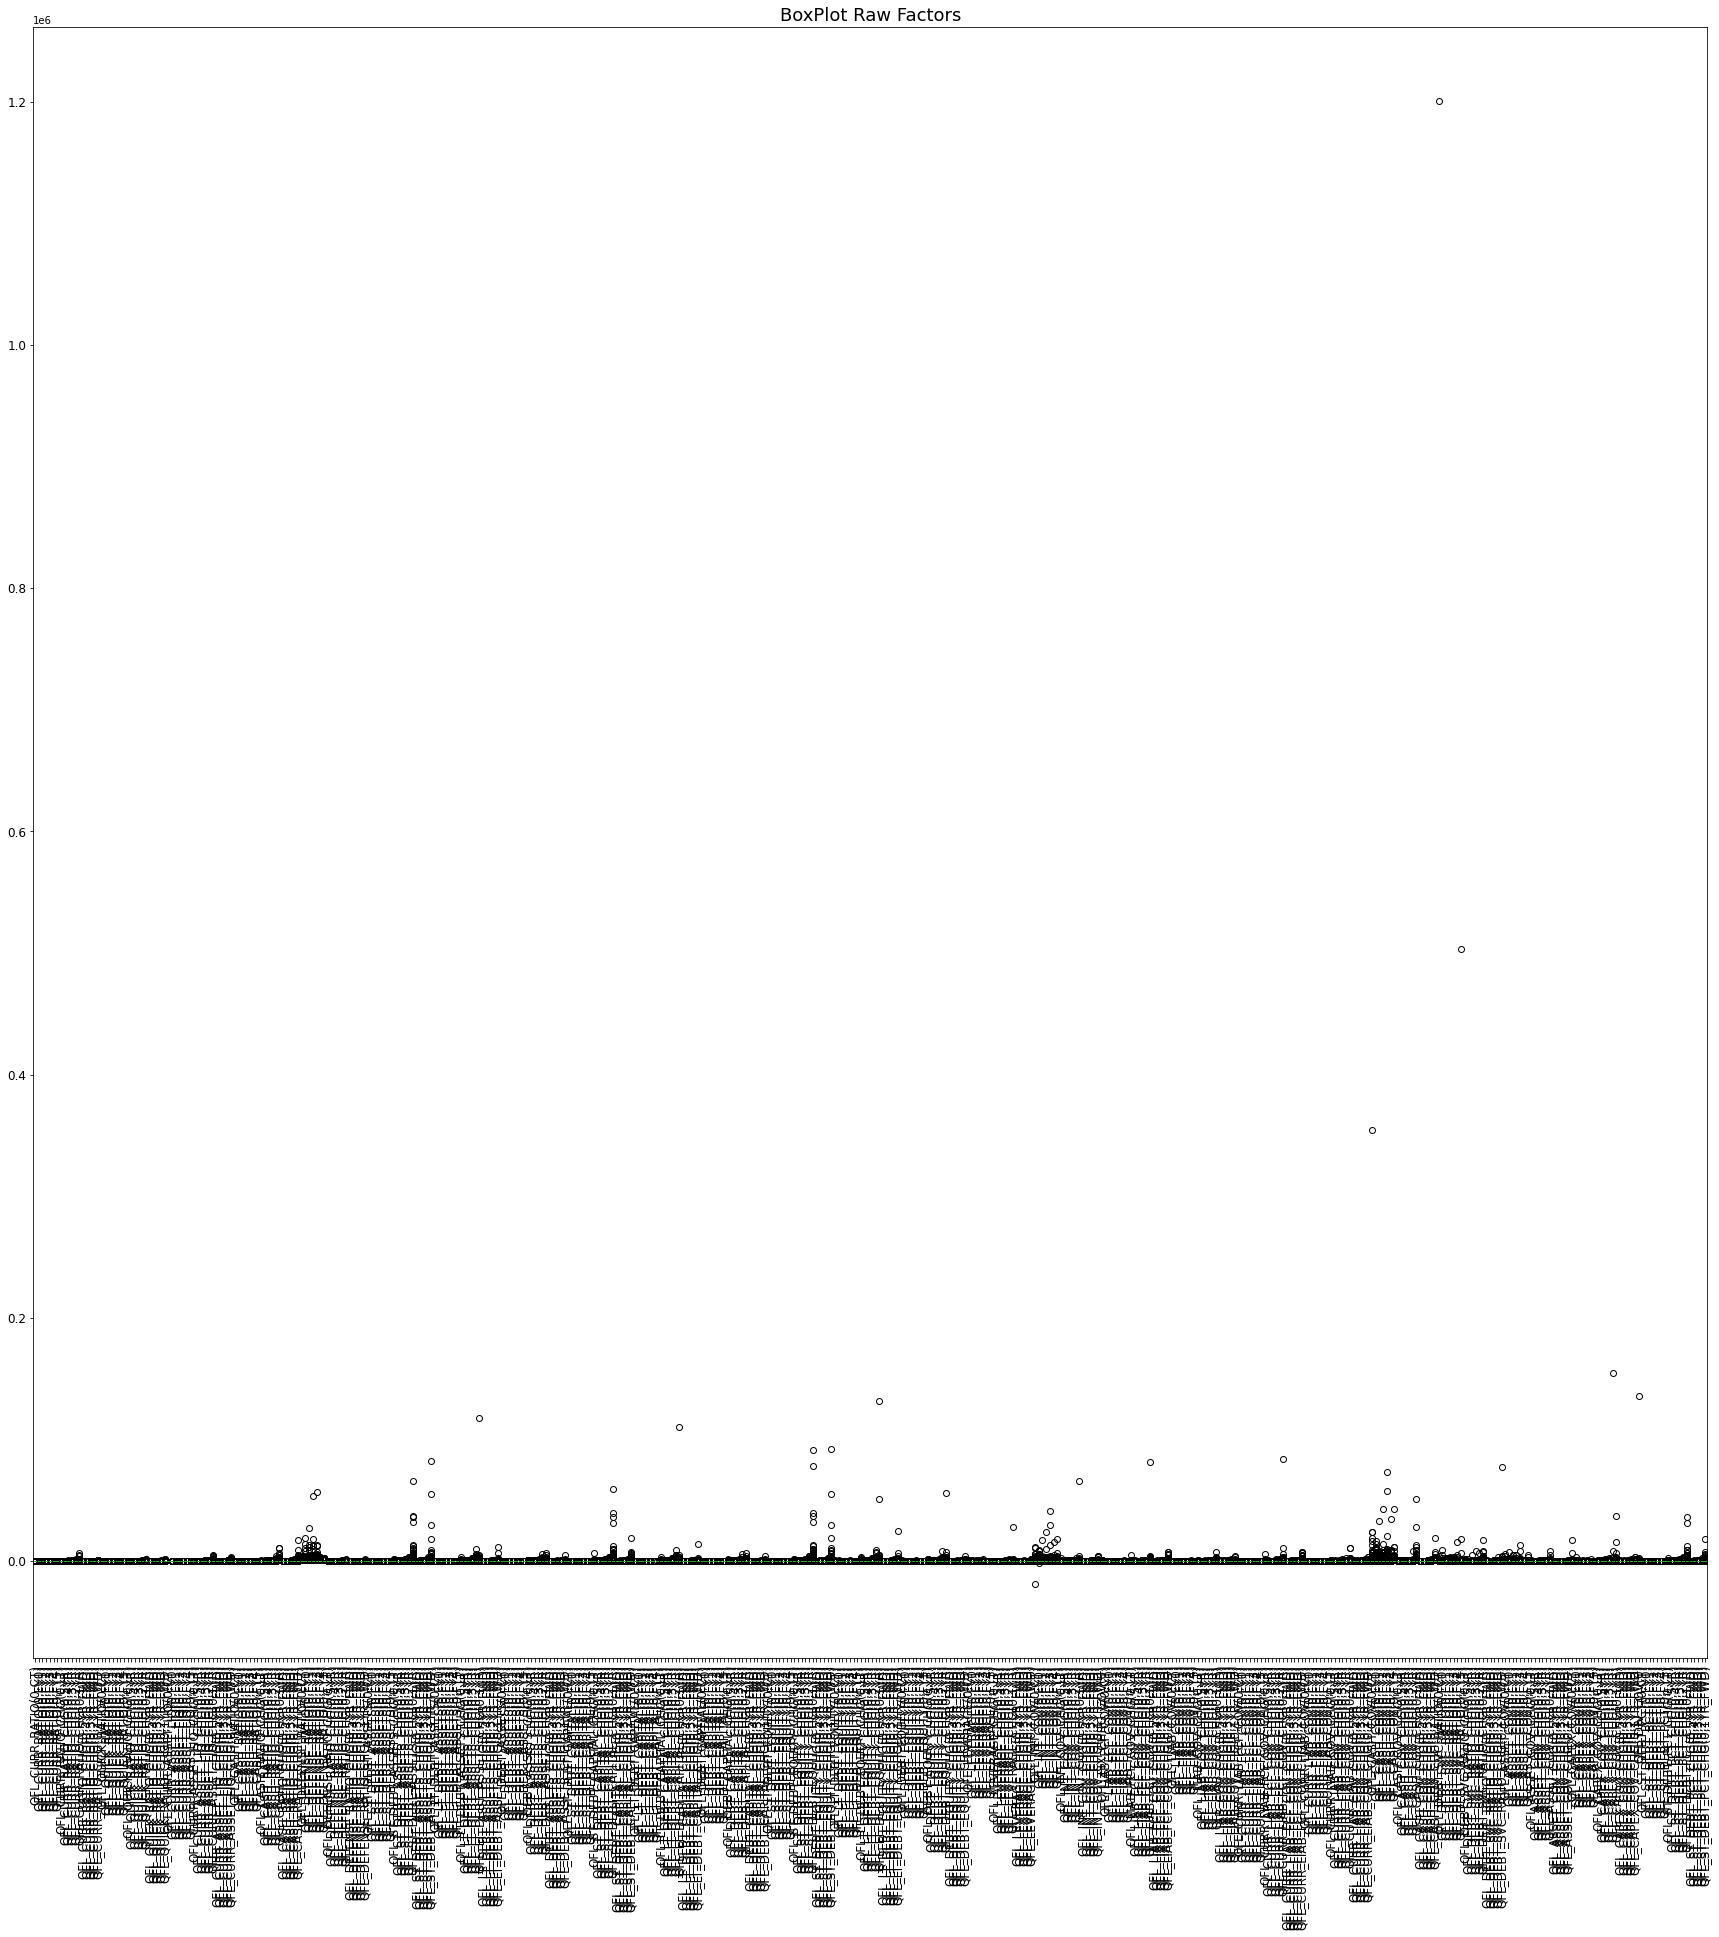

In [17]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [18]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

QFL_CURR_RATIO(0,CT)  QFL_CURR_RATIO(0,FY0)  QFL_CURR_RATIO(0,FY1)  \
count          1.436000e+03           1.238000e+03           1.292000e+03   
mean          -6.148363e-16          -6.187834e-17           7.130519e-16   
std            1.000000e+00           1.000000e+00           1.000000e+00   
min           -4.327164e-01          -1.177029e+00          -9.634554e-01   
25%           -2.379192e-01          -5.345626e-01          -4.705517e-01   
50%           -1.486037e-01          -2.850348e-01          -2.650737e-01   
75%            1.188691e-02           1.685870e-01           1.020894e-01   
max            2.899852e+01           8.478836e+00           1.523801e+01   

       QFL_CURR_RATIO(0,FY2)  QFL_CURR_RATIO(0,FY3)  QFL_CURR_RATIO(0,FY4)  \
count           1.290000e+03           1.240000e+03           6.330000e+02   
mean            8.069342e-16          -3.319925e-16          -6.922670e-16   
std             1.000000e+00           1.000000e+00           1.000000e+00   
min            -9.405503e-01          -8.846306e-01          -6.110847e-01   
25%            -4.671173e-01          -4.463233e-01          -3.597408e-01   
50%            -2.696625e-01          -2.553601e-01          -2.381353e-01   
75%             9.753485e-02           8.841866e-02           4.440116e-02   
max             1.277752e+01           1.754794e+01           1.644876e+01   

       QFL_CURR_RATIO(0,FY5)  QFL_CURR_RATIO_CHG(0,LT)  \
count           4.890000e+02              1.505000e+03   
mean            1.938917e-16             -2.517366e-17   
std             1.000000e+00              1.000000e+00   
min            -6.356263e-01             -6.077567e+00   
25%            -4.009158e-01             -4.091664e-01   
50%            -2.613995e-01             -1.122638e-01   
75%             7.823750e-02              2.535820e-01   
max             1.168527e+01              1.016528e+01   

       QFL_CURR_RATIO_CHG(0,5YR)  QFL_CURR_RATIO_CHG(0,4YR)  \
count               1.365000e+03               1.384000e+03   
mean                2.592554e-18              -1.082949e-16   
std                 1.000000e+00               1.000000e+00   
min                -4.926288e+00              -4.744375e+00   
25%                -4.025163e-01              -3.937511e-01   
50%                -5.833870e-02              -6.961639e-02   
75%                 2.906508e-01               2.375140e-01   
max                 1.152146e+01               1.648835e+01   

       QFL_CURR_RATIO_CHG(0,3YR)  QFL_CURR_RATIO_CHG(0,2YR)  \
count               1.409000e+03               1.428000e+03   
mean                1.418706e-16               2.438914e-16   
std                 1.000000e+00               1.000000e+00   
min                -3.139699e+00              -1.129717e+00   
25%                -3.308469e-01              -2.315134e-01   
50%                -9.331242e-02              -9.992901e-02   
75%                 1.471716e-01               3.815500e-02   
max                 1.765014e+01               2.582014e+01   

       QFL_CURR_RATIO_CHG(0,1YR)  QFL_CURR_RATIO_CHG(0,5YR_FWD)  \
count               1.431000e+03                   4.620000e+02   
mean                9.451637e-17                   2.689047e-16   
std                 1.000000e+00                   1.000000e+00   
min                -5.044698e-01                  -3.778832e+00   
25%                -1.478821e-01                  -5.043828e-01   
50%                -1.016980e-01                  -1.593851e-01   
75%                -2.907347e-02                   3.242169e-01   
max                 2.451112e+01                   7.227177e+00   

       QFL_CURR_RATIO_CHG(0,4YR_FWD)  QFL_CURR_RATIO_CHG(0,3YR_FWD)  \
count                   6.010000e+02                   1.169000e+03   
mean                    2.912257e-16                   1.736089e-16   
std                     1.000000e+00                   1.000000e+00   
min                    -4.827247e+00                  -3.305293

In [19]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

QFL_CURR_RATIO(0,CT)  QFL_CURR_RATIO(0,FY0)  QFL_CURR_RATIO(0,FY1)  \
0                28.998521               8.478836              15.238008   
1                16.182603               8.252000               9.594945   
2                 6.816758               7.375291               8.174392   
3                 5.078906               6.260214               7.054396   
4                 4.659785               5.356555               6.728190   
...                    ...                    ...                    ...   
1595                   NaN                    NaN                    NaN   
1596                   NaN                    NaN                    NaN   
1597                   NaN                    NaN                    NaN   
1598                   NaN                    NaN                    NaN   
1599                   NaN                    NaN                    NaN   

      QFL_CURR_RATIO(0,FY2)  QFL_CURR_RATIO(0,FY3)  QFL_CURR_RATIO(0,FY4)  \
0                 12.777518              17.547944              16.448759   
1                 11.311916              11.016923               8.660986   
2                  9.696601              10.563002               6.982498   
3                  8.865176               6.682509               6.664463   
4                  7.963179               6.593666               4.502812   
...                     ...                    ...                    ...   
1595                    NaN                    NaN                    NaN   
1596                    NaN                    NaN                    NaN   
1597                    NaN                    NaN                    NaN   
1598                    NaN                    NaN                    NaN   
1599                    NaN                    NaN                    NaN   

      QFL_CURR_RATIO(0,FY5)  QFL_CURR_RATIO_CHG(0,LT)  \
0                 11.685273                 10.165275   
1                 10.955020                  7.610463   
2                  6.923056                  6.791239   
3                  4.425792                  6.646751   
4                  4.106150                  6.449213   
...                     ...                       ...   
1595                    NaN                       NaN   
1596                    NaN                       NaN   
1597                    NaN                       NaN   
1598                    NaN                       NaN   
1599                    NaN                       NaN   

      QFL_CURR_RATIO_CHG(0,5YR)  QFL_CURR_RATIO_CHG(0,4YR)  \
0                     11.521455                  16.488345   
1                     10.077450                  12.453216   
2                      7.622795                   7.391414   
3                      6.835687                   7.215816   
4                      6.696864                   6.777705   
...                         ...                        ...   
1595                        NaN                        NaN   
1596                        NaN                        NaN   
1597                        NaN                        NaN   
1598                        NaN                        NaN   
1599                        NaN                        NaN   

      QFL_CURR_RATIO_CHG(0,3YR)  QFL_CURR_RATIO_CHG(0,2YR)  \
0                     17.650138                  25.820136   
1                     14.379050                  15.112922   
2                      9.330802                  12.419121   
3                      8.469697                   9.543523   
4                      8.355033                   4.516424   
...                         ...                        ...   
1595                        NaN                        NaN   
1596                        NaN                        NaN   
1597                        NaN                        NaN   
1598                        NaN                        NaN   
1599                        NaN                        N

In [20]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

QFL_CURR_RATIO(0,CT)  QFL_CURR_RATIO(0,FY0)  QFL_CURR_RATIO(0,FY1)  \
0                -0.432716              -1.177029              -0.963455   
1                -0.430044              -1.091552              -0.894045   
2                -0.426027              -1.084387              -0.893193   
3                -0.425291              -1.062391              -0.859643   
4                -0.424057              -1.034113              -0.846824   
...                    ...                    ...                    ...   
1595                   NaN                    NaN                    NaN   
1596                   NaN                    NaN                    NaN   
1597                   NaN                    NaN                    NaN   
1598                   NaN                    NaN                    NaN   
1599                   NaN                    NaN                    NaN   

      QFL_CURR_RATIO(0,FY2)  QFL_CURR_RATIO(0,FY3)  QFL_CURR_RATIO(0,FY4)  \
0                 -0.940550              -0.884631              -0.611085   
1                 -0.880151              -0.871830              -0.567986   
2                 -0.873929              -0.825116              -0.552792   
3                 -0.842434              -0.817869              -0.547907   
4                 -0.837880              -0.792441              -0.545253   
...                     ...                    ...                    ...   
1595                    NaN                    NaN                    NaN   
1596                    NaN                    NaN                    NaN   
1597                    NaN                    NaN                    NaN   
1598                    NaN                    NaN                    NaN   
1599                    NaN                    NaN                    NaN   

      QFL_CURR_RATIO(0,FY5)  QFL_CURR_RATIO_CHG(0,LT)  \
0                 -0.635626                 -6.077567   
1                 -0.623639                 -5.073666   
2                 -0.618129                 -4.141685   
3                 -0.613221                 -3.301345   
4                 -0.601214                 -3.151266   
...                     ...                       ...   
1595                    NaN                       NaN   
1596                    NaN                       NaN   
1597                    NaN                       NaN   
1598                    NaN                       NaN   
1599                    NaN                       NaN   

      QFL_CURR_RATIO_CHG(0,5YR)  QFL_CURR_RATIO_CHG(0,4YR)  \
0                     -4.926288                  -4.744375   
1                     -4.564072                  -4.177049   
2                     -2.876336                  -3.612884   
3                     -2.861232                  -2.488814   
4                     -2.720905                  -2.366949   
...                         ...                        ...   
1595                        NaN                        NaN   
1596                        NaN                        NaN   
1597                        NaN                        NaN   
1598                        NaN                        NaN   
1599                        NaN                        NaN   

      QFL_CURR_RATIO_CHG(0,3YR)  QFL_CURR_RATIO_CHG(0,2YR)  \
0                     -3.139699                  -1.129717   
1                     -2.885972                  -1.128145   
2                     -2.567281                  -1.092754   
3                     -2.501795                  -1.082148   
4                     -2.097901                  -1.000493   
...                         ...                        ...   
1595                        NaN                        NaN   
1596                        NaN                        NaN   
1597                        NaN                        NaN   
1598                        NaN                        NaN   
1599                        NaN                        N

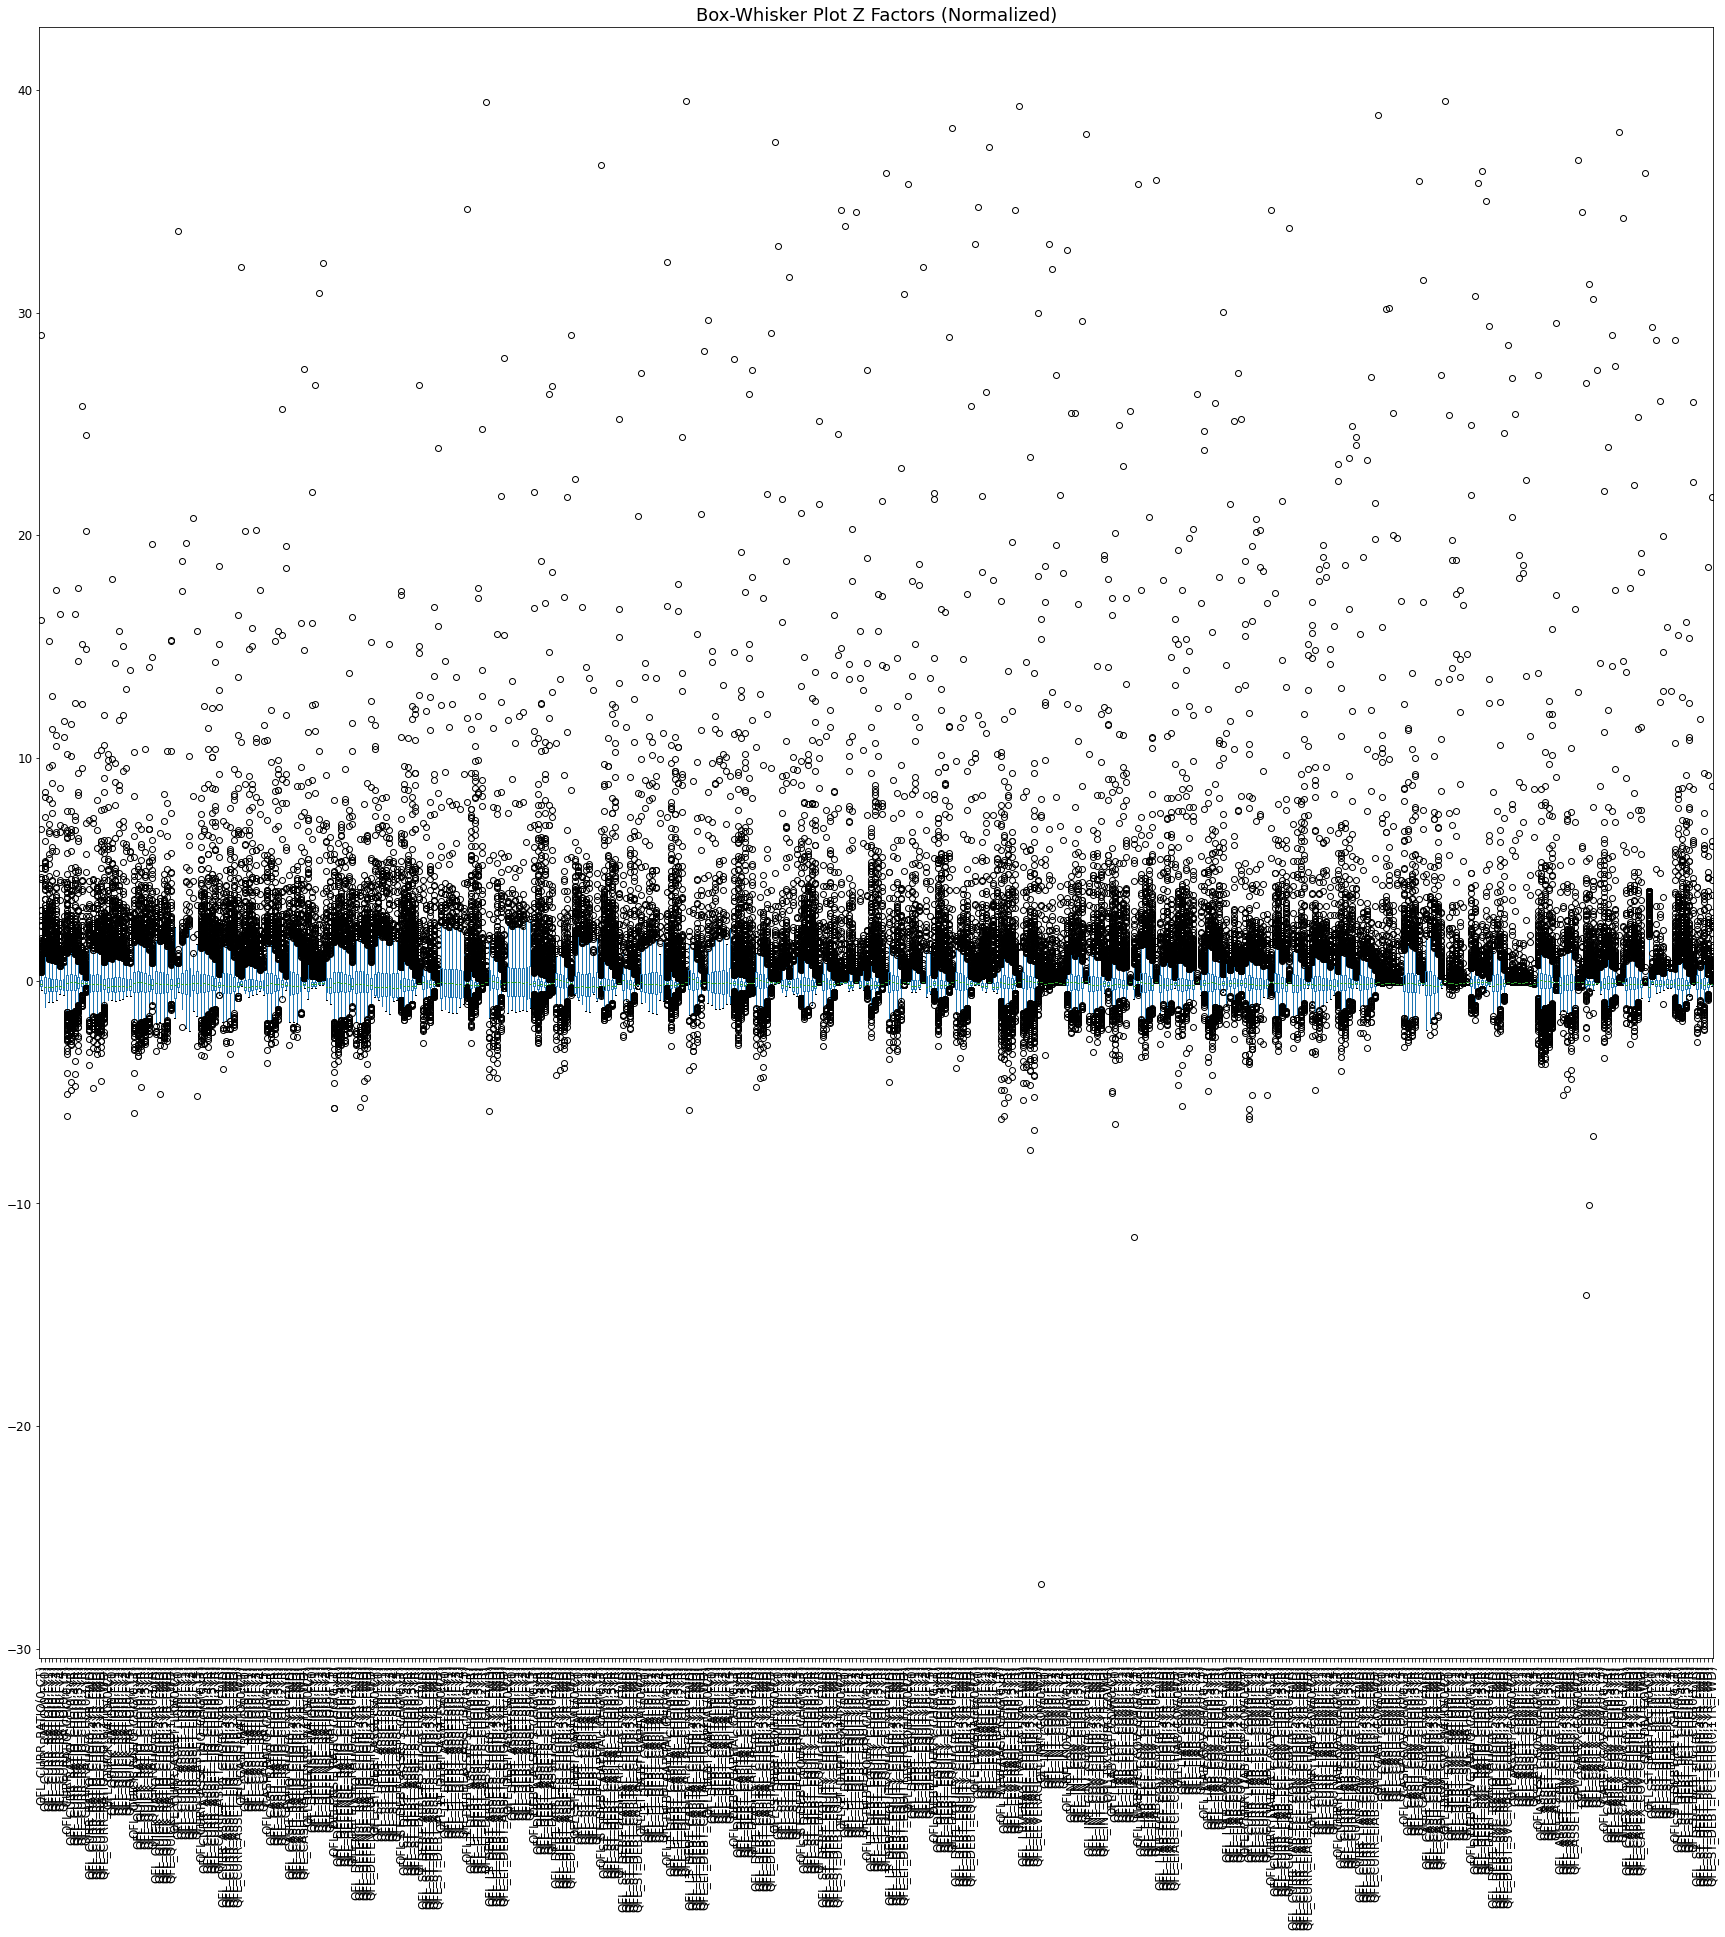

In [21]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [22]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

QFL_CURR_RATIO(0,CT)  QFL_CURR_RATIO(0,FY0)  QFL_CURR_RATIO(0,FY1)  \
0             -0.432716              -1.177029              -0.963455   
1             -0.430044              -1.091552              -0.894045   
2             -0.426027              -1.084387              -0.893193   
3             -0.425291              -1.062391              -0.859643   
4             -0.424057              -1.034113              -0.846824   

   QFL_CURR_RATIO(0,FY2)  QFL_CURR_RATIO(0,FY3)  QFL_CURR_RATIO(0,FY4)  \
0              -0.940550              -0.884631              -0.611085   
1              -0.880151              -0.871830              -0.567986   
2              -0.873929              -0.825116              -0.552792   
3              -0.842434              -0.817869              -0.547907   
4              -0.837880              -0.792441              -0.545253   

   QFL_CURR_RATIO(0,FY5)  QFL_CURR_RATIO_CHG(0,LT)  QFL_CURR_RATIO_CHG(0,5YR)  \
0              -0.635626                 -6.077567                  -4.926288   
1              -0.623639                 -5.073666                  -4.564072   
2              -0.618129                 -4.141685                  -2.876336   
3              -0.613221                 -3.301345                  -2.861232   
4              -0.601214                 -3.151266                  -2.720905   

   QFL_CURR_RATIO_CHG(0,4YR)  QFL_CURR_RATIO_CHG(0,3YR)  \
0                  -4.744375                  -3.139699   
1                  -4.177049                  -2.885972   
2                  -3.612884                  -2.567281   
3                  -2.488814                  -2.501795   
4                  -2.366949                  -2.097901   

   QFL_CURR_RATIO_CHG(0,2YR)  QFL_CURR_RATIO_CHG(0,1YR)  \
0                  -1.129717                  -0.504470   
1                  -1.128145                  -0.466168   
2                  -1.092754                  -0.446779   
3                  -1.082148                  -0.436410   
4                  -1.000493                  -0.435961   

   QFL_CURR_RATIO_CHG(0,5YR_FWD)  QFL_CURR_RATIO_CHG(0,4YR_FWD)  \
0                      -3.778832                      -4.827247   
1                      -3.184171                      -3.030019   
2                      -2.633824                      -2.722928   
3                      -2.239900                      -2.454125   
4                      -2.230550                      -2.375647   

   QFL_CURR_RATIO_CHG(0,3YR_FWD)  QFL_CURR_RATIO_CHG(0,2YR_FWD)  \
0                      -3.305293                      -4.514938   
1                      -3.050177                      -3.265275   
2                      -2.851381                      -2.956352   
3                      -2.521652                      -2.724127   
4                      -2.462493                      -2.687276   

   QFL_CURR_RATIO_CHG(0,1YR_FWD)  QFL_QUICK_RATIO(0,CT)  \
0                      -2.458231              -0.872063   
1                      -2.322061              -0.863805   
2                      -1.908817              -0.862452   
3                      -1.859722              -0.841786   
4                      -1.697261              -0.832633   

   QFL_QUICK_RATIO(0,FY0)  QFL_QUICK_RATIO(0,FY1)  QFL_QUICK_RATIO(0,FY2)  \
0               -0.857356               -0.913195               -0.858284   
1               -0.845974               -0.906281               -0.850782   
2               -0.831030               -0.903252               -0.845166   
3               -0.830868               -0.889661               -0.837605   
4               -0.826920               -0.887315               -0.832140   

   QFL_QUICK_RATIO(0,FY3)  QFL_QUICK_RATIO(0,FY4)  QFL_QUICK_RATIO(0,FY5)  \
0               -0.832283               -0.675898               -0.695445   
1               -0.831437               -0.659058               -0.603008   
2               -0.827175               -0.616032               -0.

In [23]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

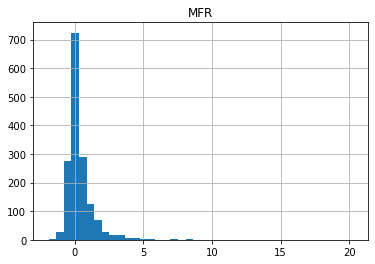

In [24]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [25]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


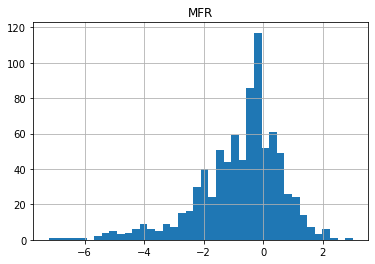

In [26]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [27]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

QFL_CURR_RATIO(0,CT)  QFL_CURR_RATIO(0,FY0)  QFL_CURR_RATIO(0,FY1)  \
0                 0.310131               1.363604               0.353711   
1                 0.927290               2.515765               0.923953   
2                 0.103004               1.097048               0.146034   
3                 1.706375               4.399455               1.645665   
4                 1.226755               3.374052               1.248080   
...                    ...                    ...                    ...   
1595                   NaN                    NaN               1.190705   
1596              0.629976                    NaN                    NaN   
1597                   NaN                    NaN              -1.790750   
1598              0.490752               1.309816               0.008904   
1599              1.429946               4.666666               1.532595   

      QFL_CURR_RATIO(0,FY2)  QFL_CURR_RATIO(0,FY3)  QFL_CURR_RATIO(0,FY4)  \
0                  0.378284               1.763542               1.160131   
1                  0.986593               2.939824                    NaN   
2                  0.309657               1.629234               0.776470   
3                  1.704142               6.157394               2.076603   
4                  1.285277               3.845135               1.502642   
...                     ...                    ...                    ...   
1595               0.877139               2.223496                    NaN   
1596                    NaN                    NaN                    NaN   
1597              -1.760895               0.160768                    NaN   
1598              -0.096658               0.910454               0.117139   
1599               1.541634               4.833910               1.562396   

      QFL_CURR_RATIO(0,FY5)  QFL_CURR_RATIO_CHG(0,LT)  \
0                  1.316438                 19.311539   
1                       NaN                  3.780432   
2                  0.949729                 16.074202   
3                  2.222430                  8.338570   
4                  1.592685                  4.147742   
...                     ...                       ...   
1595                    NaN                       NaN   
1596                    NaN                 -6.677234   
1597                    NaN                       NaN   
1598              -0.074443                 -2.581653   
1599               1.598291                  1.216321   

      QFL_CURR_RATIO_CHG(0,5YR)  QFL_CURR_RATIO_CHG(0,4YR)  \
0                      4.949510                   3.571796   
1                      1.111722                   0.802445   
2                      1.072598                   2.207875   
3                    -20.534557                 -26.233418   
4                    -11.088467                 -17.573755   
...                         ...                        ...   
1595                        NaN                        NaN   
1596                  -6.677234                  -5.808194   
1597                        NaN                        NaN   
1598                   1.152027                   2.686441   
1599                   1.327205                  -2.194142   

      QFL_CURR_RATIO_CHG(0,3YR)  QFL_CURR_RATIO_CHG(0,2YR)  \
0                      6.171954                  10.201764   
1                     -6.239253                  -7.434380   
2                      2.762198                   1.941347   
3                    -30.653227                 -17.147505   
4                    -14.511835                  -9.619892   
...                         ...                        ...   
1595                        NaN                        NaN   
1596                        NaN                   1.971924   
1597                        NaN                        NaN   
1598                   1.052356                   5.140245   
1599                  -3.699094                  -6.7999

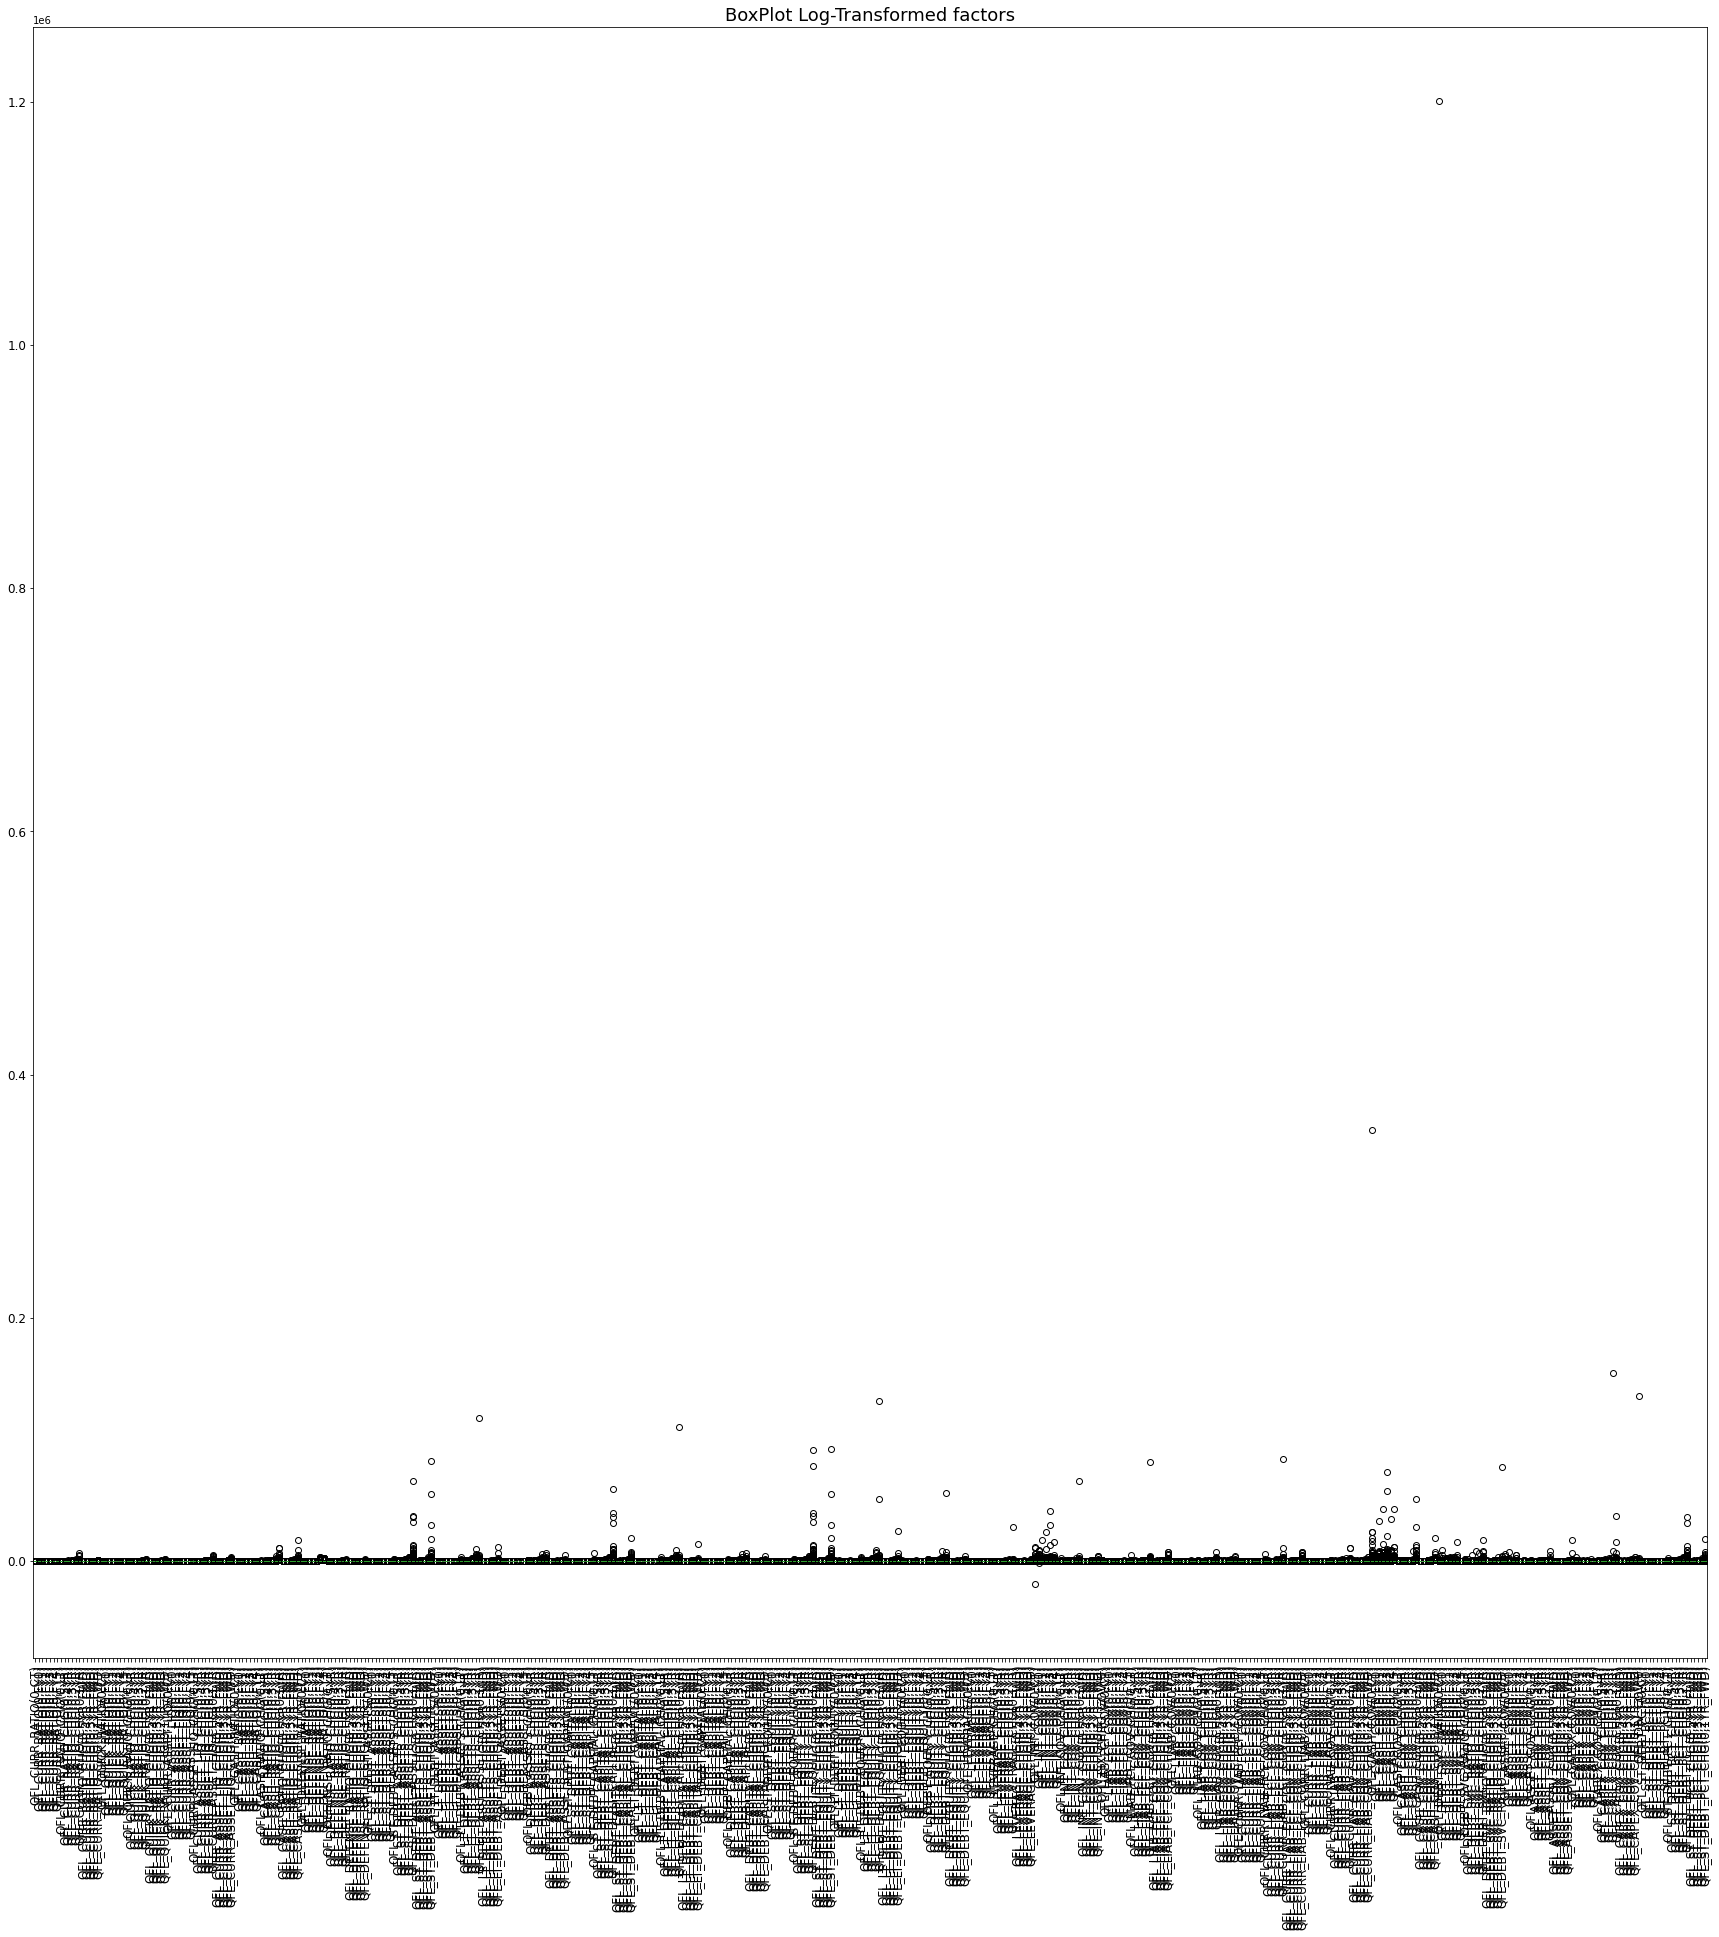

In [28]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [29]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

QFL_CURR_RATIO(0,CT)  QFL_CURR_RATIO(0,FY0)  QFL_CURR_RATIO(0,FY1)  \
0             -0.100804              -0.313172              -0.153058   
1              0.687681               0.416733               0.687734   
2             -0.365430              -0.482038              -0.459267   
3              1.683046               1.610069               1.751861   
4              1.070280               0.960466               1.165642   

   QFL_CURR_RATIO(0,FY2)  QFL_CURR_RATIO(0,FY3)  QFL_CURR_RATIO(0,FY4)  \
0              -0.172807              -0.196538               0.693298   
1               0.709706               0.259460                    NaN   
2              -0.272370              -0.248604               0.189502   
3               1.750699               1.506783               1.896745   
4               1.143025               0.610413               1.143060   

   QFL_CURR_RATIO(0,FY5)  QFL_CURR_RATIO_CHG(0,LT)  QFL_CURR_RATIO_CHG(0,5YR)  \
0               0.736525                  1.303171                   0.391746   
1                    NaN                 -0.014847                   0.078828   
2               0.277885                  1.028441                   0.075638   
3               1.869641                  0.371971                  -1.686127   
4               1.082025                  0.016324                  -0.915929   

   QFL_CURR_RATIO_CHG(0,4YR)  QFL_CURR_RATIO_CHG(0,3YR)  \
0                   0.167322                   0.142135   
1                  -0.007022                  -0.353410   
2                   0.081457                   0.005993   
3                  -1.709068                  -1.328194   
4                  -1.163898                  -0.683712   

   QFL_CURR_RATIO_CHG(0,2YR)  QFL_CURR_RATIO_CHG(0,1YR)  \
0                   0.023228                  -0.176998   
1                  -0.254109                  -0.180261   
2                  -0.106671                  -0.112638   
3                  -0.406854                  -0.010410   
4                  -0.288478                  -0.158125   

   QFL_CURR_RATIO_CHG(0,5YR_FWD)  QFL_CURR_RATIO_CHG(0,4YR_FWD)  \
0                       1.885760                       1.293453   
1                            NaN                            NaN   
2                       1.437120                       1.083880   
3                       1.017983                       0.736278   
4                       0.249475                       0.080527   

   QFL_CURR_RATIO_CHG(0,3YR_FWD)  QFL_CURR_RATIO_CHG(0,2YR_FWD)  \
0                       0.158807                      -0.233820   
1                      -0.071708                      -0.245922   
2                       0.658624                       0.218870   
3                       0.399733                       0.236650   
4                      -0.157305                      -0.230862   

   QFL_CURR_RATIO_CHG(0,1YR_FWD)  QFL_QUICK_RATIO(0,CT)  \
0                      -0.213542              -0.020021   
1                      -0.314299               1.067300   
2                      -0.189455              -0.218700   
3                       0.098971               2.195374   
4                      -0.241696               1.538479   

   QFL_QUICK_RATIO(0,FY0)  QFL_QUICK_RATIO(0,FY1)  QFL_QUICK_RATIO(0,FY2)  \
0               -0.663323               -0.327306               -0.346224   
1               -0.402783               -0.188459                0.145969   
2               -0.367708               -0.362547               -0.119440   
3                1.000173                0.999367                1.613824   
4                0.144070                0.070986                0.414304   

   QFL_QUICK_RATIO(0,FY3)  QFL_QUICK_RATIO(0,FY4)  QFL_QUICK_RATIO(0,FY5)  \
0               -0.046907                0.197884                0.239109   
1                0.254028                     NaN                     NaN   
2                0.114468               -0.052490               -0.

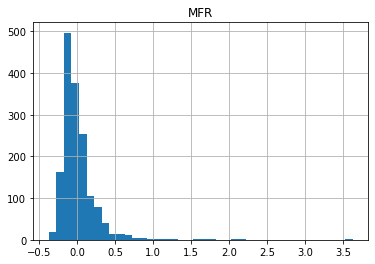

In [30]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [31]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.03
Information Coefficient (P-Value): 0.31


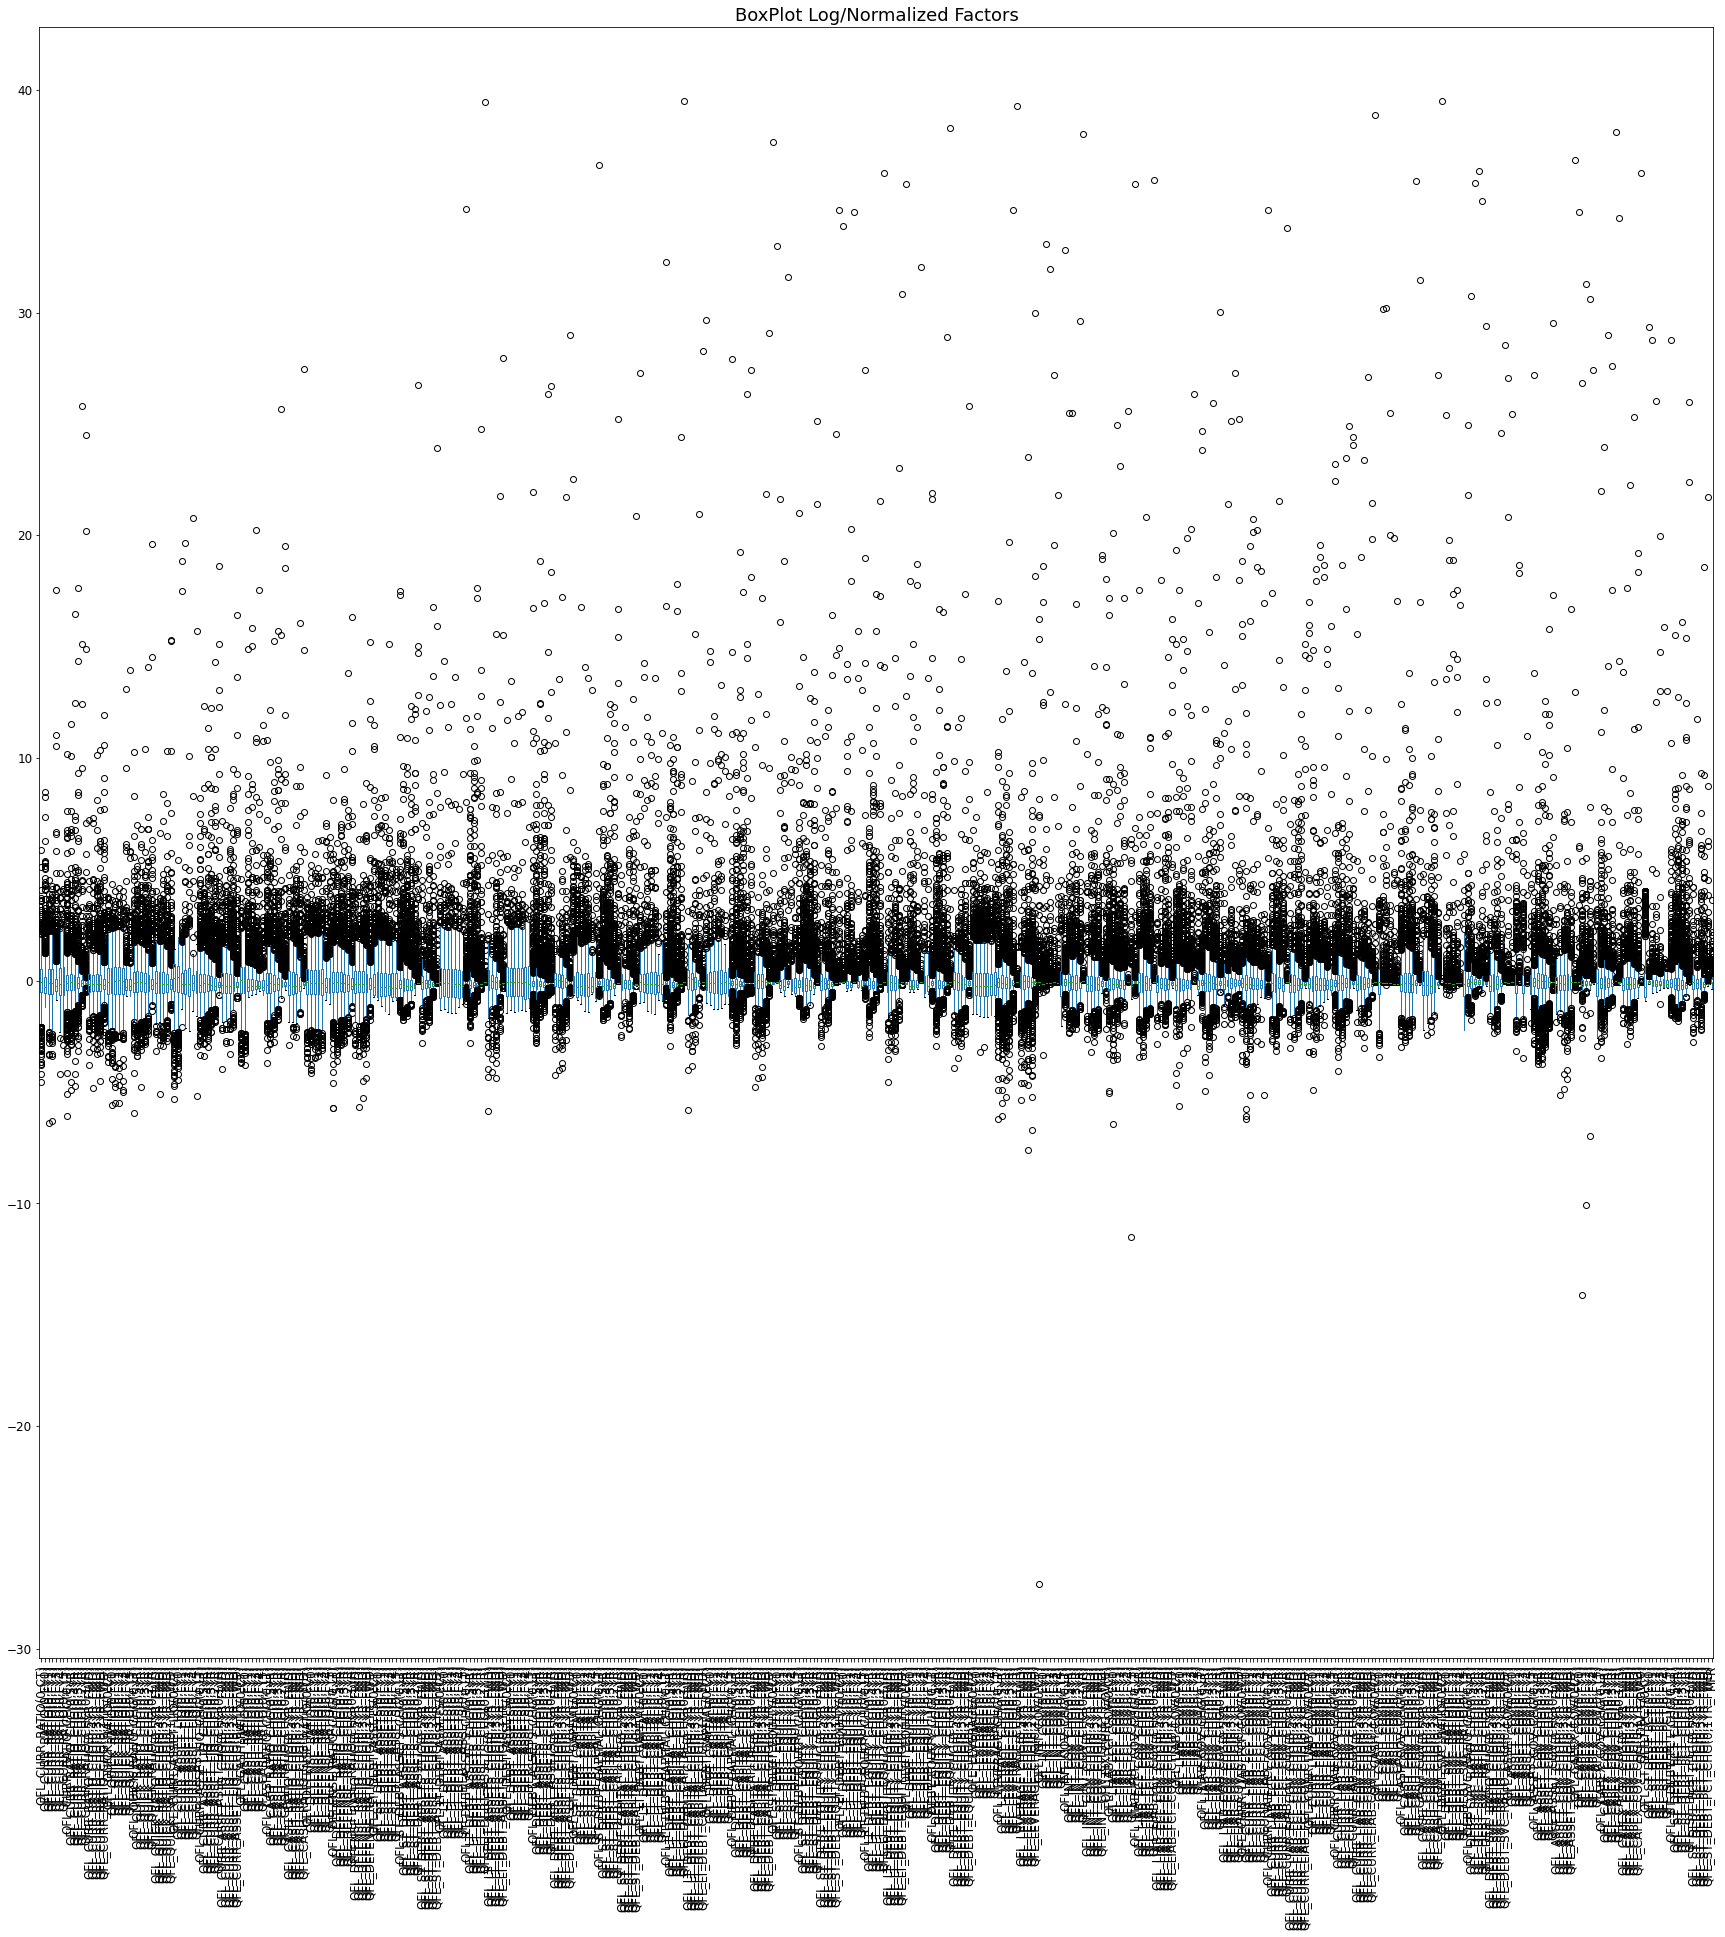

In [32]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [33]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

BENCHMARK_ID         DATE SECURITY_ID    Weight             proper_name  \
0        890100  30-Nov-2020    03783310  4.204100              Apple Inc.   
1        890100  30-Nov-2020    59491810  3.141281   Microsoft Corporation   
2        890100  30-Nov-2020    02313510  2.735749        Amazon.com, Inc.   
3        890100  30-Nov-2020    30303M10  1.356526  Facebook, Inc. Class A   
4        890100  30-Nov-2020    02079K10  1.085045   Alphabet Inc. Class C   

           fg_gics_sector         proper  p_total_return qfl_size_class  \
0  Information Technology  United States       11.457372       Mega Cap   
1  Information Technology  United States        3.900588       Mega Cap   
2  Consumer Discretionary  United States        2.805829       Mega Cap   
3  Communication Services  United States       -1.375598       Mega Cap   
4  Communication Services  United States       -0.503194       Mega Cap   

   qfl_mkt_val_sec  QFL_CURR_RATIO(0,CT)  QFL_CURR_RATIO(0,FY0)  \
0        2024064.4              1.363604               1.363604   
1        1618475.4              2.527649               2.515765   
2        1589567.8              1.108496               1.097048   
3         665827.3              5.508958               4.399455   
4         580810.4              3.410145               3.374052   

   QFL_CURR_RATIO(0,FY1)  QFL_CURR_RATIO(0,FY2)  QFL_CURR_RATIO(0,FY3)  \
0               1.424344               1.459778               1.763542   
1               2.519229               2.682082               2.939824   
2               1.157236               1.362957               1.629234   
3               5.184457               5.496665               6.157394   
4               3.483647               3.615669               3.845135   

   QFL_CURR_RATIO(0,FY4)  QFL_CURR_RATIO(0,FY5)  QFL_CURR_RATIO_CHG(0,LT)  \
0               3.190350               3.730112                 19.311539   
1                    NaN                    NaN                  3.780432   
2               2.173785               2.585010                 16.074202   
3               7.977325               9.229734                  8.338570   
4               4.493545               4.916935                  4.147742   

   QFL_CURR_RATIO_CHG(0,5YR)  QFL_CURR_RATIO_CHG(0,4YR)  \
0                   4.949510                   3.571796   
1                   1.111722                   0.802445   
2                   1.072598                   2.207875   
3                 -20.534557                 -26.233418   
4                 -11.088467                 -17.573755   

   QFL_CURR_RATIO_CHG(0,3YR)  QFL_CURR_RATIO_CHG(0,2YR)  \
0                   6.171954                  10.201764   
1                  -6.239253                  -7.434380   
2                   2.762198                   1.941347   
3                 -30.653227                 -17.147505   
4                 -14.511835                  -9.619892   

   QFL_CURR_RATIO_CHG(0,1YR)  QFL_CURR_RATIO_CHG(0,5YR_FWD)  \
0                 -12.267465                      24.393642   
1                 -13.089389                            NaN   
2                   3.945530                      19.911016   
3                  29.698002                      15.723170   
4                  -7.513213                       8.044560   

   QFL_CURR_RATIO_CHG(0,4YR_FWD)  QFL_CURR_RATIO_CHG(0,3YR_FWD)  \
0                      21.089666                       8.287024   
1                            NaN                       5.442529   
2                      18.646340                      14.454620   
3                      14.593780                      11.259986   
4                       6.948630                       4.386277   

   QFL_CURR_RATIO_CHG(0,2YR_FWD)  QFL_CURR_RATIO_CHG(0,1YR_FWD)  \
0                       3.466362                       4.454351   
1                       3.252598                       0.137687   
2                      11.462362                       5.486298   
3           

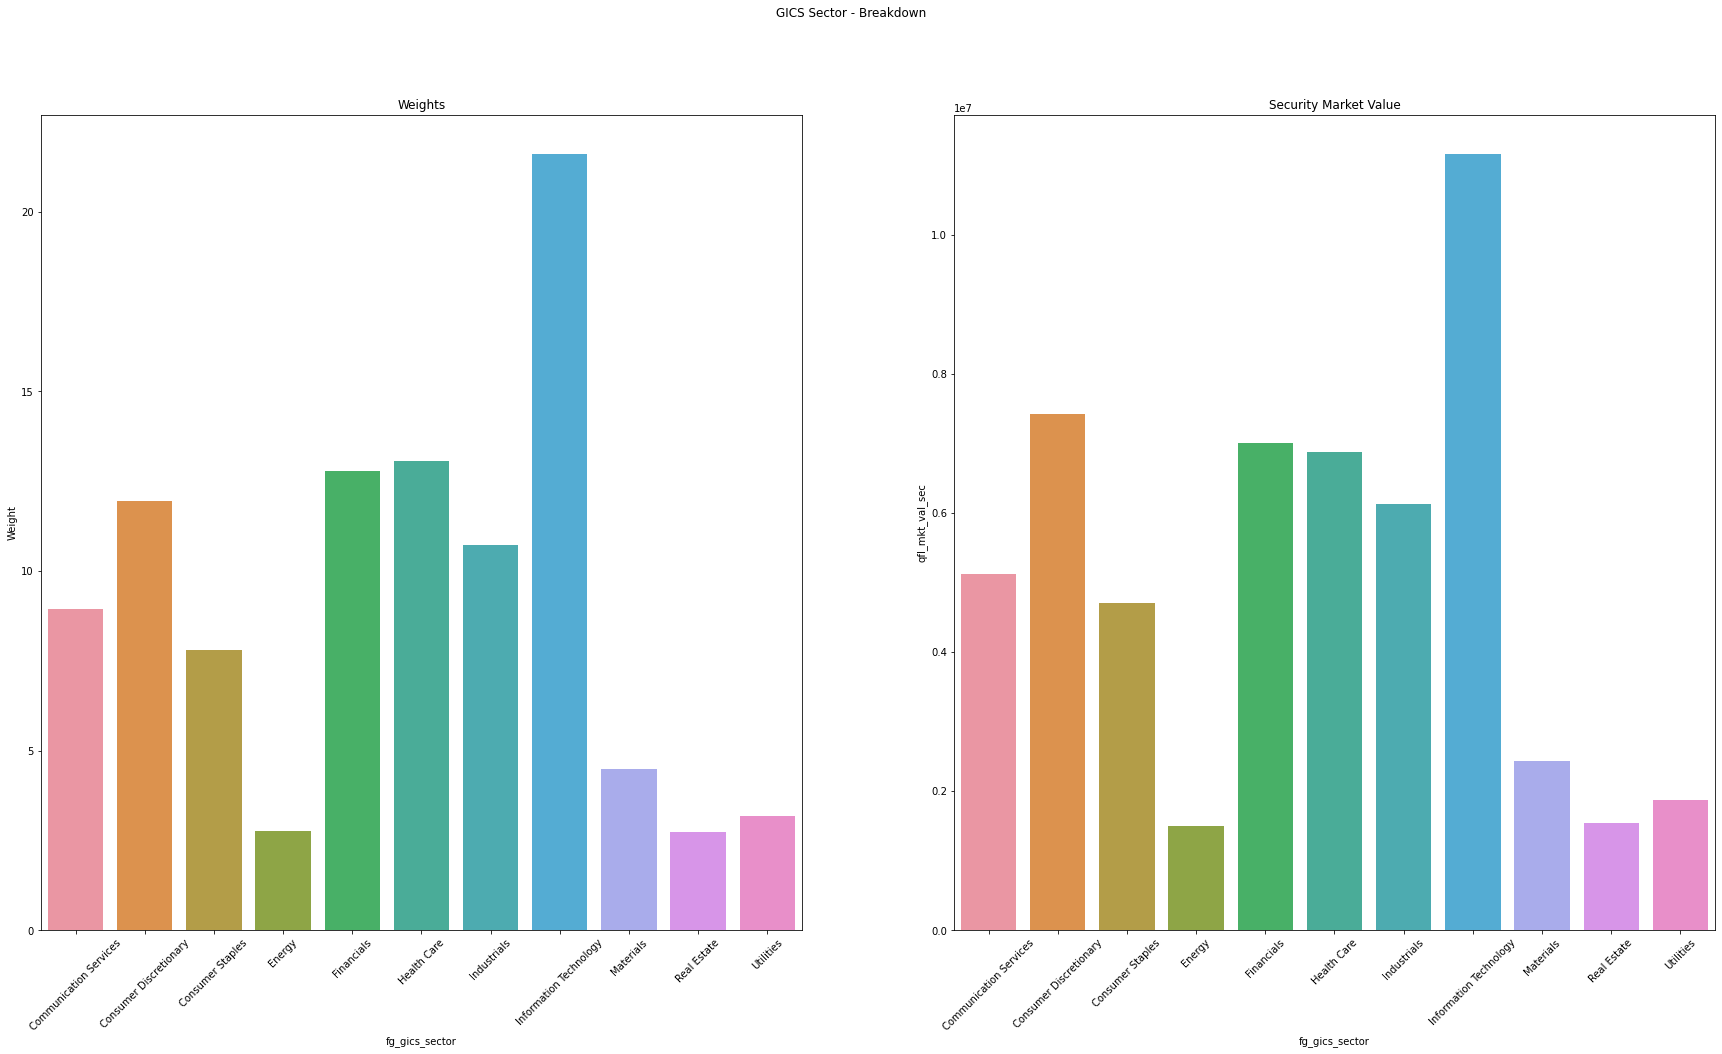

In [34]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [35]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

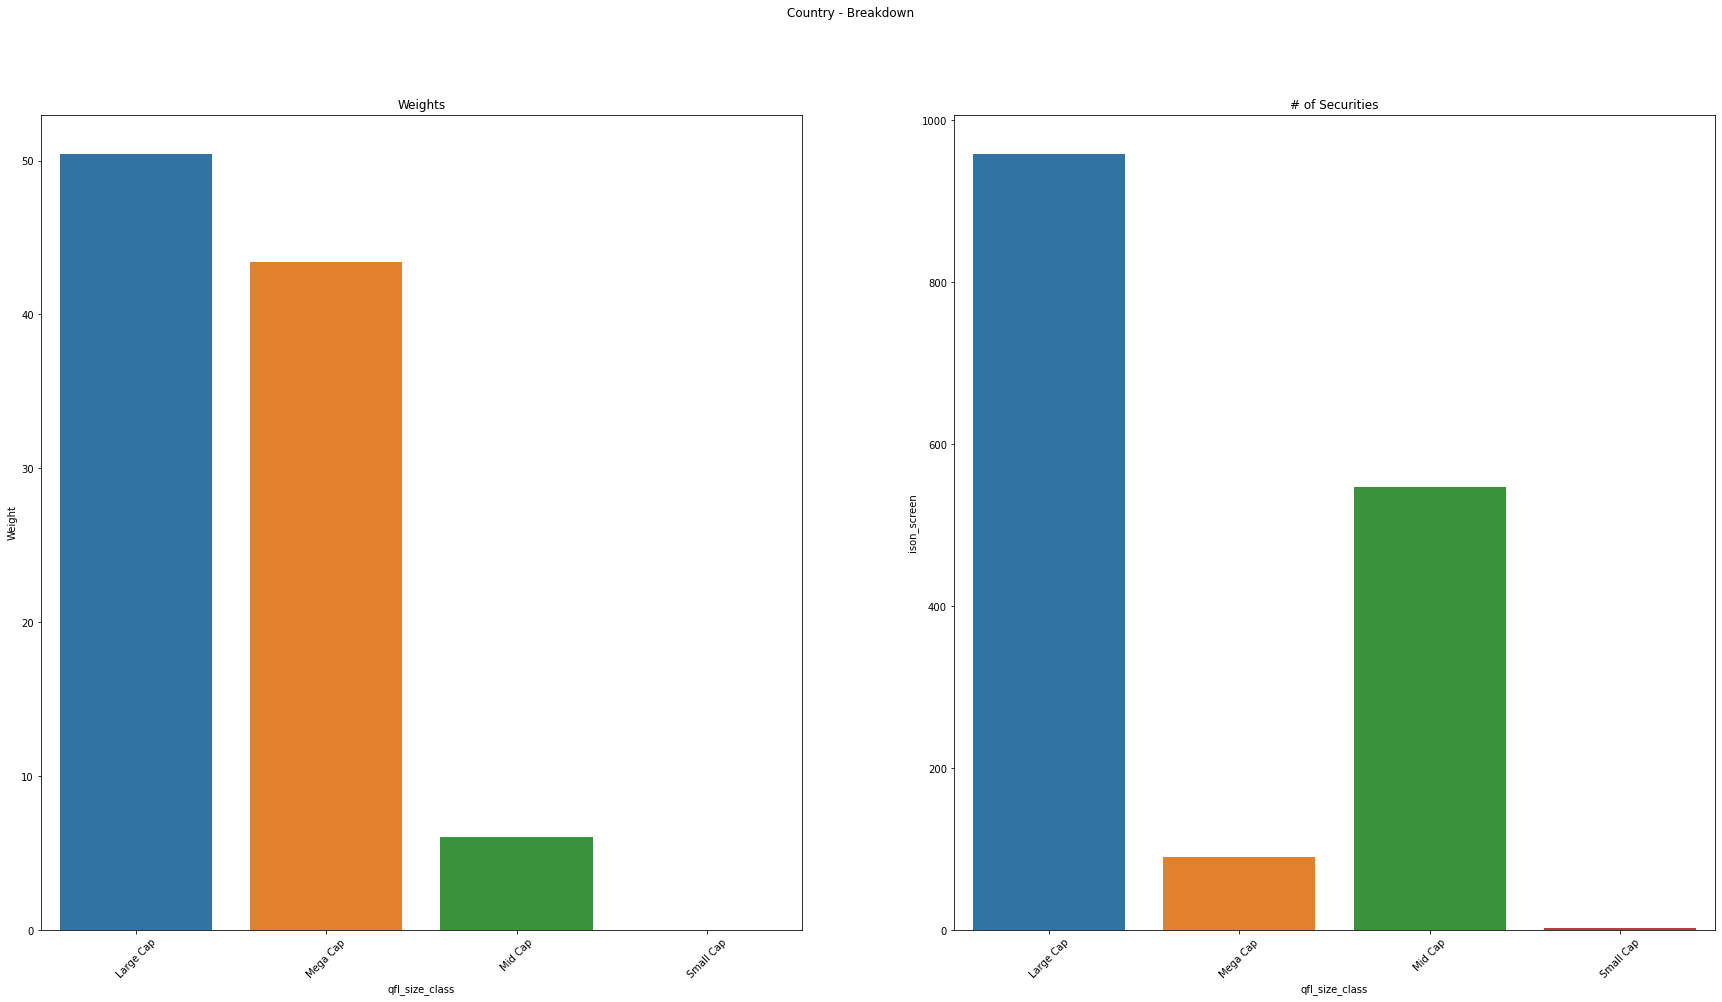

In [36]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [37]:
# Feature Selection

In [38]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [39]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-39-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [40]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35603.16682455855, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35603.16682455855, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35603.212992439956, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

Num Features: 3
Selected Features: [False False False False False False False False  True False False False
 False False False False False False  True False False False False False
 False False False False False False  True False False False False False
 False False False False False False]
Feature Ranking: [40  8 30  7 13 28 27  2  1 10 33 15 35  6 17 24  5 23  1 16 38 39 37 14
 19 31 11 34 25 26  1  9 18 36 32  3 21  4 22 20 29 12]


C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26740.129931074764, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26444.358969798814, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(


In [41]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_DEBT_ASSETS_CHG(0,2YR)', 'QFL_DEBT_CAPITAL_CHG(0,2YR)',
       'QFL_LEVERAGE_CHG(0,2YR)'],
      dtype='object')

In [42]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

QFL_DEBT_ASSETS_CHG(0,2YR)  \
QFL_DEBT_ASSETS_CHG(0,2YR)                     1.000000   
QFL_DEBT_CAPITAL_CHG(0,2YR)                    0.992963   
QFL_LEVERAGE_CHG(0,2YR)                        0.046335   

                             QFL_DEBT_CAPITAL_CHG(0,2YR)  \
QFL_DEBT_ASSETS_CHG(0,2YR)                      0.992963   
QFL_DEBT_CAPITAL_CHG(0,2YR)                     1.000000   
QFL_LEVERAGE_CHG(0,2YR)                         0.052280   

                             QFL_LEVERAGE_CHG(0,2YR)  
QFL_DEBT_ASSETS_CHG(0,2YR)                  0.046335  
QFL_DEBT_CAPITAL_CHG(0,2YR)                 0.052280  
QFL_LEVERAGE_CHG(0,2YR)                     1.000000

In [43]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

QFL_DEBT_ASSETS_CHG(0,2YR)  QFL_DEBT_CAPITAL_CHG(0,2YR)  \
0                      11.880529                    14.527237   
1                     -10.202032                   -10.511208   
2                       2.121329                    -0.940728   
3                     507.007100                   506.436070   
4                     106.908226                   104.136320   
...                          ...                          ...   
1595                    4.127765                     3.489912   
1596                   -6.222761                    -7.379353   
1597                    8.700216                     8.113718   
1598                   64.672874                    53.535890   
1599                   -0.418103                     0.125229   

      QFL_LEVERAGE_CHG(0,2YR)  
0                   22.703339  
1                   -9.025234  
2                   -4.223561  
3                    4.463887  
4                    2.728236  
...                       ...  
1595                 2.990401  
1596                -5.239856  
1597                 7.401574  
1598                14.582884  
1599                 0.599873  

[1600 rows x 3 columns]

In [44]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

QFL_DEBT_ASSETS_CHG(0,2YR)  QFL_DEBT_CAPITAL_CHG(0,2YR)  \
0                   -0.096409                    -0.068939   
1                   -0.211455                    -0.197696   
2                   -0.147252                    -0.148481   
3                    2.483114                     2.460638   
4                    0.398669                     0.391864   

   QFL_LEVERAGE_CHG(0,2YR)       MFR  
0                 0.401080  0.078577  
1                -0.361642 -0.256931  
2                -0.246215 -0.180650  
3                -0.037378  1.635458  
4                -0.079101  0.237144

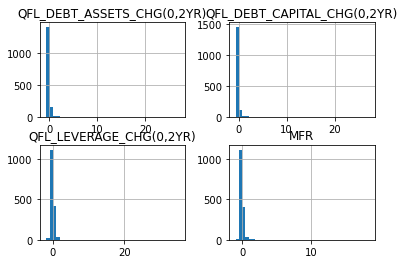

In [45]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [46]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: -0.07
Information Coefficient (P-Value): 0.0


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [47]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: -0.07
Information Coefficient (P-Value): 0.0


### Z-Score + Log-Transformation (All Components)

In [48]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.03
Information Coefficient (P-Value): 0.31


### Z-Score Only (All Components)

In [49]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04
